## Introduction  

1. Eigen Decomposition
2. Singular Value Decomposition
3. Linear Regression
4. Artificial Neural Network

### Image Conversion

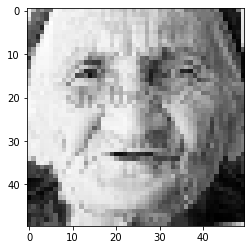

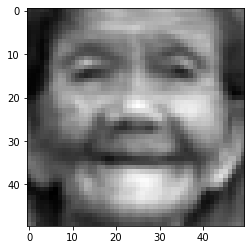

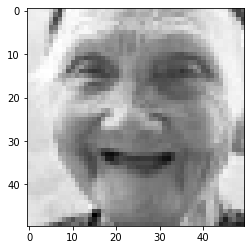

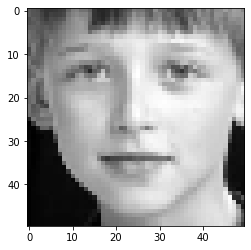

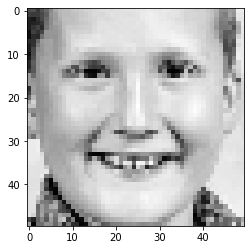

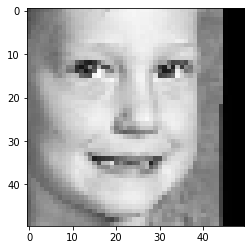

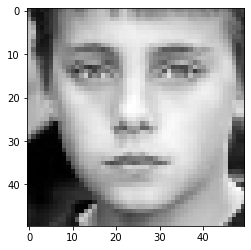

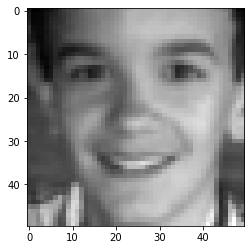

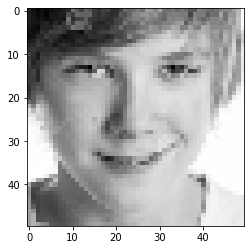

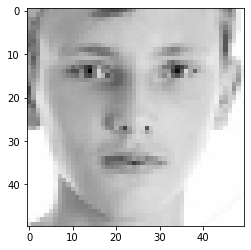

In [1]:
# importing libraries
import glob
import os
import numpy as np
from skimage import io, color, transform
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import datasets

# Load and preprocess the images
Faces = []
Ages = []
Genders = []

for k,i in enumerate(glob.glob(r"FaceData/*")):
    # Load image
    imagei = io.imread(i)
    
    Ages.append(os.path.basename(i).split("_")[0])
    Genders.append(os.path.basename(i).split("_")[1])

    # Convert to grayscale image
    imagei_gray = color.rgb2gray(imagei)
    
    # Resize image
    image_rescaled = transform.rescale(imagei_gray, 0.25, anti_aliasing=False)

    # Resize image
    Faces.append(image_rescaled.flatten())
    
    # Visualize ten images
    if(k<10):
        plt.figure()
        plt.imshow(image_rescaled, cmap='gray')
        plt.show()

###  Eigenfaces Analysis

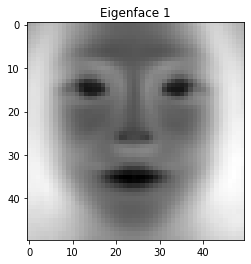

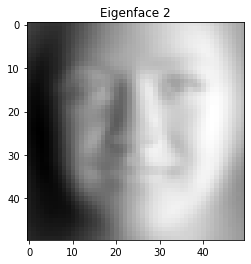

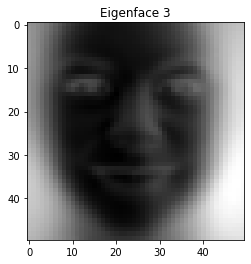

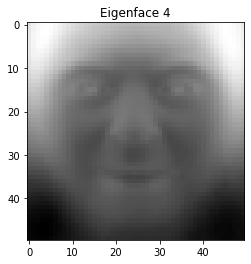

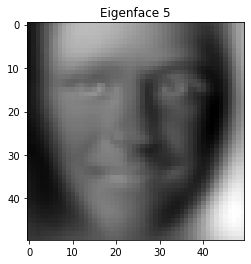

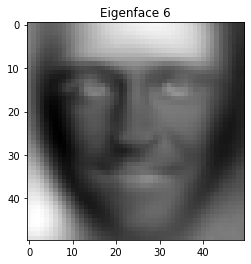

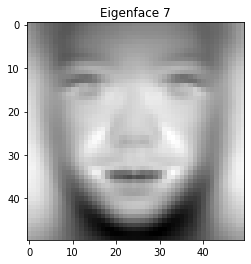

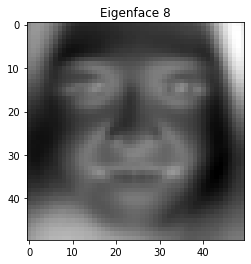

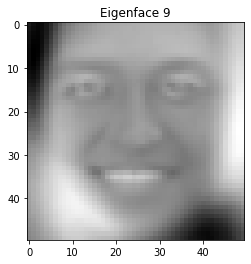

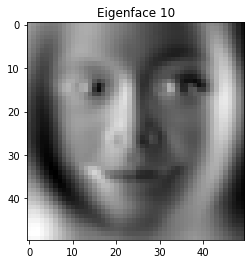

In [2]:
#Convert to matrix
Faces = np.array(Faces)

# Reshape the array
n_samples = len(Faces)
h = w = 50

X = Faces.reshape(n_samples, h * w)

# Compute the covariance matrix
covariance_matrix = np.cov(X.T)

# Perform eigendecomposition on the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]


# Visualize the eigenfaces
for i in range(10):
    eigenface = eigenvectors[:, i].reshape((h, w))
    plt.figure()
    plt.imshow(eigenface, cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.show()


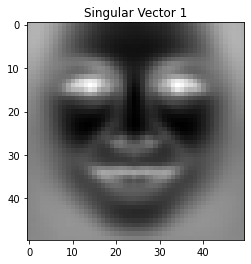

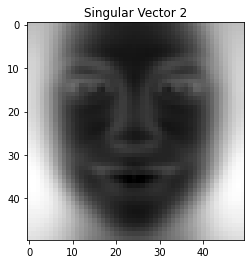

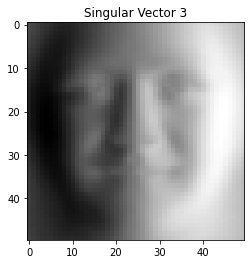

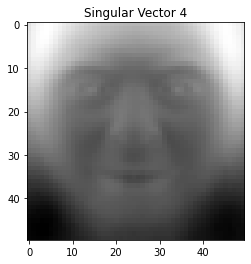

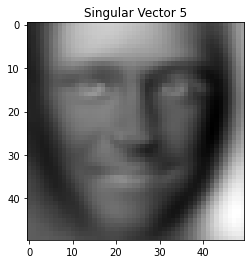

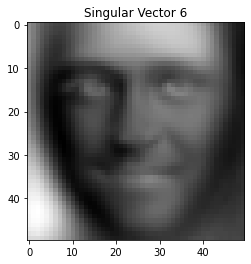

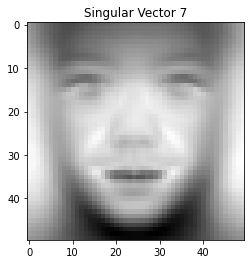

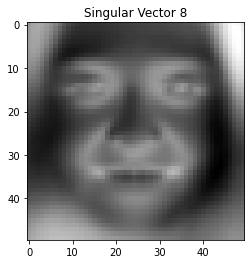

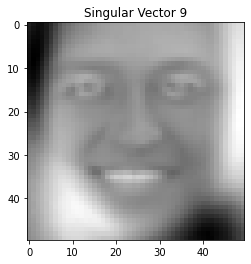

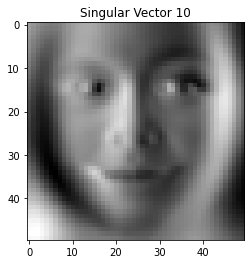

In [3]:
# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(X, full_matrices=False)

# Visualize the first 10 singular vectors as eigenfaces
for i in range(10):
    singular_vector = Vt[i].reshape((h, w))
    plt.figure()
    plt.imshow(singular_vector, cmap='gray')
    plt.title(f'Singular Vector {i+1}')
    plt.show()

## Similarities:
Visualization Oberservation : Both eigendecomposition and SVD produces a similar looking image.
Basis vectors: Both eigendecomposition and SVD can be used to compute the basis vectors (eigenfaces) that span the face image space.
Image reconstruction: Both methods allow for image reconstruction by approximating an input image using a linear combination of the basis vectors.
## Differences:
Input matrix: Eigendecomposition requires the input matrix to be square and symmetric, while SVD can be applied to any rectangular matrix. In the context of eigenfaces, the input matrix is usually square and symmetric since it represents the covariance matrix.

Basis vectors: Eigendecomposition produces the eigenvectors of the input matrix, which are used as the basis vectors (eigenfaces) in eigenfaces analysis. SVD produces two sets of orthogonal vectors, known as the left singular vectors (which correspond to eigenvectors of the input matrix) and the right singular vectors.

Sign ambiguity: Eigendecomposition does not determine the sign of the eigenvectors, meaning the direction of the eigenfaces is arbitrary. On the other hand, SVD provides a unique decomposition where both the left and right singular vectors have positive components.

Eigendecomposition is often used when the input matrix is square and symmetric, while SVD offers more flexibility and robustness for general rectangular matrices.

In [4]:
D_input = np.array(Faces).astype(float)

y_age = np.array(Ages).astype(float)/100
y_gender = np.array(Genders).astype(float)*2-1

In [5]:
y_gender

array([1., 1., 1., ..., 1., 1., 1.])

### train_test_split 

In [6]:
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(D_input, y_age, y_gender, test_size=0.1, random_state=205)


In [7]:
X_train.shape

(8802, 2500)

In [8]:
# Lambda for Tikhnov regularization

# A lot of lambda values were tested to find the best one
Lambda = [i/100.0 for i in range(1, 100, 5)]

In [9]:
# Linear regression for age prediction using matrix calculus
X_train_ones = np.concatenate([X_train.reshape(X_train.shape[0], -1), np.ones((X_train.shape[0], 1))], axis=1)
X_test_ones = np.concatenate([X_test.reshape(X_test.shape[0], -1), np.ones((X_test.shape[0], 1))], axis=1)

# Logistic regression for gender prediction using matrix calculus
X_train_gender = np.concatenate([X_train.reshape(X_train.shape[0], -1), np.ones((X_train.shape[0], 1))], axis=1)
X_test_gender = np.concatenate([X_test.reshape(X_test.shape[0], -1), np.ones((X_test.shape[0], 1))], axis=1)


# MSE and ACC
AGE_MSE = []
GENDER_ACC = []

for i in range(len(Lambda)):
    # Compute the weight matrix for age prediction using matrix calculus
    W_age = np.linalg.inv(X_train_ones.T @ X_train_ones + Lambda[i] * np.eye(2501)) @ X_train_ones.T @ y_age_train

    # Make age predictions
    y_age_pred = X_test_ones @ W_age
    
    # Compute the weight matrix for gender prediction using matrix calculus
    W_gender = np.linalg.inv(X_train_gender.T @ X_train_gender + Lambda[i] * np.eye(2501)) @ X_train_gender.T @ y_gender_train

    # Make gender predictions
    y_gender_pred = np.sign(X_test_gender @ W_gender)

    # Evaluate the models
    age_mse = mean_squared_error(y_age_test, y_age_pred)
    gender_accuracy = (y_gender_test == y_gender_pred).mean()

    # Uncomment these two lines to see the output
    # print("Age Mean Absolute Error:", age_mse)
    # print("Gender Accuracy:", gender_accuracy)

    AGE_MSE.append(age_mse)
    GENDER_ACC.append(gender_accuracy)

In [10]:
# Using SVD Features
U_train, S_train, Vt_train = np.linalg.svd(X_train, full_matrices=False)
U_test, S_test, Vt_test = np.linalg.svd(X_test, full_matrices=False)

total_variance = np.sum(S_train ** 2)
explained_variance_ratio = (S_train ** 2) / total_variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Number of components based on 95% variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

X_train_svd = U_train[:, :n_components] @ np.diag(S_train[:n_components])
X_test_svd = U_test[:, :n_components] @ np.diag(S_test[:n_components])

X_train_svd_ones = np.concatenate([X_train_svd, np.ones((X_train_svd.shape[0], 1))], axis=1)
X_test_svd_ones = np.concatenate([X_test_svd, np.ones((X_test_svd.shape[0], 1))], axis=1)

# MSE and ACC
SVD_AGE_MSE = []
SVD_GENDER_ACC = []

for i in range(len(Lambda)):
    # Compute the weight matrix for age prediction using matrix calculus
    W_age = np.linalg.inv(X_train_svd_ones.T @ X_train_svd_ones + Lambda[i] * np.eye(7)) @ X_train_svd_ones.T @ y_age_train

    # Make age predictions
    y_age_pred = X_test_svd_ones @ W_age

    # Compute the weight matrix for gender prediction using matrix calculus
    W_gender = np.linalg.inv(X_train_svd_ones.T @ X_train_svd_ones + Lambda[i] * np.eye(7)) @ X_train_svd_ones.T @ y_gender_train

    # Make gender predictions
    y_gender_pred = np.sign(X_test_svd_ones @ W_gender)

    svd_age_mse = mean_squared_error(y_age_test, y_age_pred)
    svd_gender_accuracy = (y_gender_test == y_gender_pred).mean()

    # Uncomment these two lines to see the output
    # print("SVD Age Mean Absolute Error:", svd_age_mse)
    # print("SVD Gender Accuracy:", svd_gender_accuracy)

    SVD_AGE_MSE.append(svd_age_mse)
    SVD_GENDER_ACC.append(svd_gender_accuracy)

### SVD Feature Extraction:¶
The SVD decomposition of the training and test feature matrices X_train and X_test is performed using np.linalg.svd. This results in the matrices U_train, S_train, Vt_train for the training data, and U_test, S_test, Vt_test for the test data.

The total variance of the training data is computed as the sum of squares of the singular values (S_train).

The explained variance ratio is calculated by dividing the squares of the singular values by the total variance. This represents the amount of variance explained by each singular value.

The cumulative variance ratio is obtained by cumulatively summing the explained variance ratios.

The number of components (n_components) that captures at least 95% of the variance is determined by finding the index of the first cumulative variance ratio that is greater than or equal to 0.95.

Feature Transformation:
The feature matrices are reduced to n_components dimensions by multiplying the truncated left singular vectors (U_train and U_test) with a diagonal matrix formed from the first n_components singular values (S_train[:n_components] and S_test[:n_components]). This yields the transformed feature matrices X_train_svd and X_test_svd.

In [11]:
# Without SVD => Plotting

import pandas as pd

# Create a Pandas DataFrame
df = pd.DataFrame({
    "Lambda": Lambda,
    "MSE": AGE_MSE,
    "ACC": GENDER_ACC,
    "SVD_MSE": SVD_AGE_MSE,
    "SVD_ACC": SVD_GENDER_ACC,
})

# Print the DataFrame
print(df.to_string())


    Lambda       MSE       ACC   SVD_MSE   SVD_ACC
0     0.01  0.032121  0.744376  0.066134  0.623722
1     0.06  0.031501  0.749489  0.066134  0.623722
2     0.11  0.030993  0.751534  0.066135  0.623722
3     0.16  0.030566  0.751534  0.066135  0.623722
4     0.21  0.030198  0.752556  0.066135  0.623722
5     0.26  0.029876  0.752556  0.066135  0.623722
6     0.31  0.029591  0.754601  0.066135  0.623722
7     0.36  0.029336  0.754601  0.066135  0.623722
8     0.41  0.029105  0.756646  0.066135  0.623722
9     0.46  0.028896  0.757669  0.066135  0.623722
10    0.51  0.028705  0.759714  0.066135  0.623722
11    0.56  0.028529  0.761759  0.066136  0.623722
12    0.61  0.028367  0.764826  0.066136  0.623722
13    0.66  0.028216  0.766871  0.066136  0.623722
14    0.71  0.028076  0.771984  0.066136  0.623722
15    0.76  0.027946  0.773006  0.066136  0.623722
16    0.81  0.027823  0.774029  0.066136  0.623722
17    0.86  0.027709  0.773006  0.066136  0.623722
18    0.91  0.027601  0.775051 

In [12]:
# Find the best lambda value for age prediction in the dataframe, include SVD as well

best_lambda = df[df["MSE"] == df["MSE"].min()]["Lambda"].values[0] or df[df["SVD_MSE"] == df["SVD_MSE"].min()]["Lambda"].values[0]
print("Best Lambda for Age Prediction:", best_lambda)

Best Lambda for Age Prediction: 0.96


# 
It can be seen that the model performs best when lambda is 0.96 and no svd processing is performed

In [13]:
#Store optimal data
BestLambda = 0.96
Best_W_age = np.linalg.inv(X_train_ones.T @ X_train_ones + BestLambda * np.eye(2501)) @ X_train_ones.T @ y_age_train
Best_W_gender = np.linalg.inv(X_train_gender.T @ X_train_gender + Lambda[i] * np.eye(2501)) @ X_train_gender.T @ y_gender_train

## ANN Approach

In [14]:
X_train_mean = np.mean(X_train,axis=0)[None,:]
X_train_mean

array([[0.37778933, 0.36969226, 0.36817558, ..., 0.44057508, 0.44102552,
        0.44177759]])

In [15]:
# Demean
X_train_demean = X_train - X_train_mean
X_test_demean = X_test - X_train_mean

In [16]:
Q, s, PT = np.linalg.svd(X_train_demean)

e_values_sq = s/X_train.shape[0]**0.5

In [17]:
X_train_whitten = X_train_demean@PT.T@np.linalg.inv(np.diag(e_values_sq))
X_test_whitten = X_test_demean@PT.T@np.linalg.inv(np.diag(e_values_sq))

In [18]:
k = 2
X_train_whitten_reduced = X_train_demean@PT.T[:,:k]@np.linalg.inv(np.diag(e_values_sq[:k]))
X_test_whitten_reduced = X_test_demean@PT.T[:,:k]@np.linalg.inv(np.diag(e_values_sq[:k]))

### SGD

In [20]:
#Age model
y_train = y_age_train
y_test = y_age_test

neuron_in_hidden_layer = 2 # number of hidden neuron in the hidden layer

W_hidden = np.random.randn(neuron_in_hidden_layer,X_train_whitten_reduced.shape[1]+1)/k

W_output = np.random.randn(1,neuron_in_hidden_layer+1)/neuron_in_hidden_layer


def SGD_AGE_predict(X, W_hidden,W_output):
    
    y_pred = []
    for i in range(X.shape[0]):
        x_i = X[i:i+1]
        x_i_1 = np.hstack([x_i,[[1]]])
        x_h_i = sigmoid(W_hidden@x_i_1.T)
        x_h_i_1 = np.vstack([x_h_i,[1]])
        x_o = W_output@x_h_i_1
        y_pred.append([x_o[0][0]])
        
    return np.array(y_pred),x_h_i_1,x_i_1


def sigmoid(y):
    return 1/(1+np.exp(-y))

learning_rate = 0.01

for e in range(20):# for each epoch
    for i in range(X_train.shape[0]):
        x_i = X_train_whitten_reduced[i:i+1]
        y_i = y_train[i]
        
        y_pred_i,x_h_i_1,x_i_1 = SGD_AGE_predict(x_i, W_hidden,W_output)

        delta_k = y_i - y_pred_i
        
        #Gradient for output layer
        Gradient_output  = -delta_k*x_h_i_1.T
        
        # Gradient Descent rule
        W_output = W_output -  learning_rate*Gradient_output

        
        delta_h = x_h_i_1*(1-x_h_i_1)*W_output.T*delta_k
        
        # Update each hidden unit
        Gradient_hidden = np.zeros_like(W_hidden)
        for h in range(W_hidden.shape[0]):
            
            #Gradient for hidden layer
            Gradient_hidden[h,:] =  - delta_h[h] * x_i_1
            
        # Gradient Descent rule
        W_hidden = W_hidden -  learning_rate * Gradient_hidden
    
    
    y_pred,_,_ = SGD_AGE_predict(X_train_whitten_reduced, W_hidden,W_output)
    print(mean_squared_error(y_train,y_pred))
    

#Test on tests set
y_pred_test,_,_ = SGD_AGE_predict(X_test_whitten_reduced, W_hidden,W_output)
sgd_age_test = mean_squared_error(y_test,y_pred_test)
print("MSE on test set with SGD:")
print(sgd_age_test)

#Save weight parameter
SGD_AGE_W_hidden =  W_hidden
SGD_AGE_W_output = W_output

0.05966353248932006
0.05958726254162009
0.059569863176439884
0.059552877724198476
0.05953549343177359
0.05951797248849929
0.059500424874591645
0.05948285142433611
0.05946520157866409
0.05944740365990123
0.05942937905840569
0.05941104859287947
0.05939233527731713
0.05937316549583805
0.05935346950683233
0.059333181706791846
0.05931224087631508
0.05929059055843232
0.05926817971386207
0.05924496382537087
MSE on test set with SGD:
0.059266529212253546


In [21]:
#Gender model
y_train = y_gender_train
y_test = y_gender_test

neuron_in_hidden_layer = 2 # number of hidden neuron in the hidden layer

W_hidden = np.random.randn(neuron_in_hidden_layer,X_train_whitten_reduced.shape[1]+1)/k

W_output = np.random.randn(1,neuron_in_hidden_layer+1)/neuron_in_hidden_layer


def SGD_GENDER_predict(X, W_hidden,W_output):
    
    y_pred = []
    for i in range(X.shape[0]):
        x_i = X[i:i+1]
        x_i_1 = np.hstack([x_i,[[1]]])
        x_h_i = sigmoid(W_hidden@x_i_1.T)
        x_h_i_1 = np.vstack([x_h_i,[1]])
        x_o = W_output@x_h_i_1
        y_pred.append([x_o[0][0]])
        
    return np.array(y_pred),x_h_i_1,x_i_1


def sigmoid(y):
    return 1/(1+np.exp(-y))

learning_rate = 0.01

for e in range(20):# for each epoch
    for i in range(X_train.shape[0]):
        x_i = X_train_whitten_reduced[i:i+1]
        y_i = y_train[i]
        
        y_pred_i,x_h_i_1,x_i_1 = SGD_GENDER_predict(x_i, W_hidden,W_output)

        delta_k = y_i - y_pred_i
        
        #Gradient for output layer
        Gradient_output  = -delta_k*x_h_i_1.T
        
        # Gradient Descent rule
        W_output = W_output -  learning_rate*Gradient_output

        
        delta_h = x_h_i_1*(1-x_h_i_1)*W_output.T*delta_k
        
        # Update each hidden unit
        Gradient_hidden = np.zeros_like(W_hidden)
        for h in range(W_hidden.shape[0]):
            
            #Gradient for hidden layer
            Gradient_hidden[h,:] =  - delta_h[h] * x_i_1
            
        # Gradient Descent rule
        W_hidden = W_hidden -  learning_rate * Gradient_hidden
    
    
    y_pred,_,_ = SGD_GENDER_predict(X_train_whitten_reduced, W_hidden,W_output)
    print(y_train>0,y_pred[:,0]>0)
    print(y_train,y_pred[:,0])
    print("Accuracy:",np.sum(np.sign(y_train)==np.sign(y_pred[:,0]))/y_train.shape[0])

#Test on test set
y_pred_test,_,_ = SGD_GENDER_predict(X_test_whitten_reduced, W_hidden,W_output)
sgd_gender_test = np.sum(np.sign(y_test)==np.sign(y_pred_test[:,0]))/y_test.shape[0]
print("Accuracy on test set with SGD:",sgd_gender_test)

#Save weight parameter
SGD_GENDER_W_hidden =  W_hidden
SGD_GENDER_W_output = W_output

[ True False False ...  True  True False] [ True  True  True ... False  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [ 0.03251578  0.13073704  0.03035149 ... -0.06281896  0.0361867
  0.01446098]
Accuracy: 0.5721426948420814
[ True False False ...  True  True False] [ True  True  True ... False  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [ 0.02630022  0.13669866  0.02028522 ... -0.04904616  0.02468236
  0.01461462]
Accuracy: 0.5697568734378551
[ True False False ...  True  True False] [ True  True  True ... False  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [ 0.02437577  0.13426025  0.01774826 ... -0.04081013  0.0214634
  0.01509677]
Accuracy: 0.5700977050670302
[ True False False ...  True  True False] [ True  True  True ... False  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [ 0.02342675  0.13152229  0.01675386 ... -0.03447245  0.01997972
  0.0156902 ]
Accuracy: 0.5699840945239718
[ True False False ...  True  True False] [ True  True  True ... False  True  True]
[ 1. -1. -1. ...  1.  1. -1.] 

### Adam

In [27]:
#Age model
y_train = y_age_train
y_test = y_age_test

neuron_in_hidden_layer = 2 # number of hidden neuron in the hidden layer

W_hidden = np.random.randn(neuron_in_hidden_layer,X_train_whitten_reduced.shape[1]+1)/k

W_output = np.random.randn(1,neuron_in_hidden_layer+1)/neuron_in_hidden_layer

# Define the parameters of Adam optimization algorithm
beta1 = 0.9 #The exponential decay rate of the first moment estimate
beta2 = 0.999 #Second order moment estimated exponential decay rate
epsilon = 1e-8 #Avoid dividing decimals by zero
epoch = 20 #Cycle number
num_examples = X_train_whitten_reduced.shape[0]

# Initialize the first and second moment estimates of Adam
m_W_hidden = np.zeros_like(W_hidden)
v_W_hidden = np.zeros_like(W_hidden)
m_W_output = np.zeros_like(W_output)
v_W_output = np.zeros_like(W_output)


def ADAM_AGE_predict(X, W_hidden,W_output):
    
    y_pred = []
    for i in range(X.shape[0]):
        x_i = X[i:i+1]
        x_i_1 = np.hstack([x_i,[[1]]])
        x_h_i = sigmoid(W_hidden@x_i_1.T)
        x_h_i_1 = np.vstack([x_h_i,[1]])
        x_o = W_output@x_h_i_1
        y_pred.append([x_o[0][0]])
        
    return np.array(y_pred),x_h_i_1,x_i_1


def sigmoid(y):
    return 1/(1+np.exp(-y))

learning_rate = 0.01

for e in range(20):# for each epoch
    for i in range(X_train.shape[0]):
        x_i = X_train_whitten_reduced[i:i+1]
        y_i = y_train[i]
        
        y_pred_i,x_h_i_1,x_i_1 = ADAM_AGE_predict(x_i, W_hidden,W_output)

        delta_k = y_i - y_pred_i
        
        #Gradient for output layer
        Gradient_output  = -delta_k*x_h_i_1.T
        
        # Update first and second moment estimates
        m_W_output = beta1 * m_W_output + (1 - beta1) * Gradient_output
        v_W_output = beta2 * v_W_output + (1 - beta2) * (Gradient_output**2)

        # Adam optimization algorithm was used to update the weight of the output layer
        m_W_output_hat = m_W_output / (1 - beta1**(epoch*num_examples + i + 1))
        v_W_output_hat = v_W_output / (1 - beta2**(epoch*num_examples + i + 1))
        W_output -= learning_rate * m_W_output_hat / (np.sqrt(v_W_output_hat) + epsilon)

        
        delta_h = x_h_i_1*(1-x_h_i_1)*W_output.T*delta_k
        
        # Update each hidden unit
        Gradient_hidden = np.zeros_like(W_hidden)
        for h in range(W_hidden.shape[0]):
            
            #Gradient for hidden layer
            Gradient_hidden[h,:] =  - delta_h[h] * x_i_1
         
        # Update first and second moment estimates    
        m_W_hidden = beta1 * m_W_hidden + (1 - beta1) * Gradient_hidden
        v_W_hidden = beta2 * v_W_hidden + (1 - beta2) * (Gradient_hidden**2)

        # Adam optimization algorithm is used to update the hidden layer weight
        m_W_hidden_hat = m_W_hidden / (1 - beta1**(epoch*num_examples + i + 1))
        v_W_hidden_hat = v_W_hidden / (1 - beta2**(epoch*num_examples + i + 1))
        W_hidden -= learning_rate * m_W_hidden_hat / (np.sqrt(v_W_hidden_hat) + epsilon)
    
    
    y_pred,_,_ = ADAM_AGE_predict(X_train_whitten_reduced, W_hidden,W_output)
    print(mean_squared_error(y_train,y_pred))
    
#Test on tests set
y_pred_test,_,_ = ADAM_AGE_predict(X_test_whitten_reduced, W_hidden,W_output)
adam_age_test = mean_squared_error(y_test,y_pred_test)
print("MSE on test set with adam:")
print(adam_age_test)

#Save weight parameter
ADAM_AGE_W_hidden =  W_hidden
ADAM_AGE_W_output = W_output

0.06025312768794514
0.05954037908712942
0.05937916770933055
0.05931729857818623
0.05928223641538995
0.05926036609692365
0.05924613631017258
0.059241103031351994
0.05936946489807452
0.0594200555430393
0.05946808854586425
0.059504796332441504
0.05953314634109543
0.05955589211296091
0.059574741357343995
0.05959076914042326
0.05960468223082139
0.05961687585547509
0.05962736211713811
0.05963571907263072
MSE on test set with adam:
0.0595782220617443


In [29]:
#gender model
y_train = y_gender_train
y_test = y_gender_test

neuron_in_hidden_layer = 2 # number of hidden neuron in the hidden layer

W_hidden = np.random.randn(neuron_in_hidden_layer,X_train_whitten_reduced.shape[1]+1)/k

W_output = np.random.randn(1,neuron_in_hidden_layer+1)/neuron_in_hidden_layer

# Define the parameters of Adam optimization algorithm
beta1 = 0.9 #The exponential decay rate of the first moment estimate
beta2 = 0.999 #Second order moment estimated exponential decay rate
epsilon = 1e-8 #Avoid dividing decimals by zero
epoch = 20 #Cycle number

# Initialize the first and second moment estimates of Adam
m_W_hidden = np.zeros_like(W_hidden)
v_W_hidden = np.zeros_like(W_hidden)
m_W_output = np.zeros_like(W_output)
v_W_output = np.zeros_like(W_output)


def ADAM_GENDER_predict(X, W_hidden,W_output):
    
    y_pred = []
    for i in range(X.shape[0]):
        x_i = X[i:i+1]
        x_i_1 = np.hstack([x_i,[[1]]])
        x_h_i = sigmoid(W_hidden@x_i_1.T)
        x_h_i_1 = np.vstack([x_h_i,[1]])
        x_o = W_output@x_h_i_1
        y_pred.append([x_o[0][0]])
        
    return np.array(y_pred),x_h_i_1,x_i_1


def sigmoid(y):
    return 1/(1+np.exp(-y))

learning_rate = 0.01

for e in range(20):# for each epoch
    for i in range(X_train.shape[0]):
        x_i = X_train_whitten_reduced[i:i+1]
        y_i = y_train[i]
        
        y_pred_i,x_h_i_1,x_i_1 = ADAM_GENDER_predict(x_i, W_hidden,W_output)

        delta_k = y_i - y_pred_i
        
        #Gradient for output layer
        Gradient_output  = -delta_k*x_h_i_1.T
        
        # Update first and second moment estimates
        m_W_output = beta1 * m_W_output + (1 - beta1) * Gradient_output
        v_W_output = beta2 * v_W_output + (1 - beta2) * (Gradient_output**2)

        # Adam optimization algorithm was used to update the weight of the output layer
        m_W_output_hat = m_W_output / (1 - beta1**(e*num_examples + i + 1))
        v_W_output_hat = v_W_output / (1 - beta2**(e*num_examples + i + 1))
        W_output -= learning_rate * m_W_output_hat / (np.sqrt(v_W_output_hat) + epsilon)

        
        delta_h = x_h_i_1*(1-x_h_i_1)*W_output.T*delta_k
        
        # Update each hidden unit
        Gradient_hidden = np.zeros_like(W_hidden)
        for h in range(W_hidden.shape[0]):
            
            #Gradient for hidden layer
            Gradient_hidden[h,:] =  - delta_h[h] * x_i_1
         
        # Update first and second moment estimates    
        m_W_hidden = beta1 * m_W_hidden + (1 - beta1) * Gradient_hidden
        v_W_hidden = beta2 * v_W_hidden + (1 - beta2) * (Gradient_hidden**2)

        # Adam optimization algorithm is used to update the hidden layer weight
        m_W_hidden_hat = m_W_hidden / (1 - beta1**(epoch*num_examples + i + 1))
        v_W_hidden_hat = v_W_hidden / (1 - beta2**(epoch*num_examples + i + 1))
        W_hidden -= learning_rate * m_W_hidden_hat / (np.sqrt(v_W_hidden_hat) + epsilon)
    
    
    y_pred,_,_ = ADAM_GENDER_predict(X_train_whitten_reduced, W_hidden,W_output)
    print(y_train>0,y_pred[:,0]>0)
    print(y_train,y_pred[:,0])
    print("Accuracy:",np.sum(np.sign(y_train)==np.sign(y_pred[:,0]))/y_train.shape[0])

#Test on test set
y_pred_test,_,_ = ADAM_GENDER_predict(X_test_whitten_reduced, W_hidden,W_output)
adam_gender_test = np.sum(np.sign(y_test)==np.sign(y_pred_test[:,0]))/y_test.shape[0]
print("Accuracy on test set with adam:",adam_gender_test)

#Save weight parameter
ADAM_GENDER_W_hidden =  W_hidden
ADAM_GENDER_W_output = W_output

[ True False False ...  True  True False] [ True  True  True ... False  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [ 0.01621507  0.14003412  0.00744147 ... -0.00837672  0.00842243
  0.0171075 ]
Accuracy: 0.5677118836628039
[ True False False ...  True  True False] [ True  True  True ...  True  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [0.02022867 0.1192908  0.01468364 ... 0.01051436 0.01495751 0.02219337]
Accuracy: 0.5641899568279937
[ True False False ...  True  True False] [ True  True  True ...  True  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [0.02420191 0.10909293 0.02028956 ... 0.01816716 0.02043567 0.02582951]
Accuracy: 0.5530561236082708
[ True False False ...  True  True False] [ True  True  True ...  True  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [0.0265948  0.10366832 0.02350597 ... 0.02210409 0.02360564 0.0279746 ]
Accuracy: 0.5530561236082708
[ True False False ...  True  True False] [ True  True  True ...  True  True  True]
[ 1. -1. -1. ...  1.  1. -1.] [0.02825058 0.10028

### Summary
Age prediction
Accuracy on test set with adam: 0.5521472392638037
Accuracy on test set with SGD: 0.5787321063394683


Gender prediction
MSE on test set with adam:
0.0595782220617443
MSE on test set with SGD:
0.05928570174447635
Indicates that the model using SGD optimization algorithm is slightly better than the model using Adam optimization algorithm in prediction, but the difference is small.

# 
SGD (Stochastic Gradient Descent) and Adam are both commonly used optimization algorithms for training neural networks and other machine learning models. They have some differences in how they update the model parameters. Let's discuss the differences between SGD and Adam:
1.Update Rule:
SGD: It calculates the gradient on each training sample and updates the model parameters by multiplying the gradient with the learning rate. This means that each sample contributes to parameter updates, which can result in less stable update directions.
Adam: Adam combines the concepts of momentum and adaptive learning rate. It uses estimates of the first-order moment (mean gradient) and the second-order moment (gradient variance) to adjust the learning rate. Adam adapts the update speed of different parameters, focusing more on parameters with larger gradient changes, which helps converge faster to the optimal solution.

2.Learning Rate Adjustment:
SGD: It typically requires manual selection of an appropriate learning rate. If the learning rate is too large or too small, it can lead to training difficulties or slow convergence.
Adam: It dynamically adjusts the learning rate by computing the estimates of the first-order moment and the second-order moment of the gradients. Adam can automatically adapt to the changes in different parameters, reducing the need for manual learning rate tuning.

3.Memory Requirement:
SGD: It only needs to store the gradient of the current sample, resulting in lower memory requirements.
Adam: It needs to store the first-order and second-order moment estimates for each parameter, leading to higher memory requirements.

4.Convergence:
SGD: Due to potentially less stable update directions, SGD may oscillate near the optimal solution and converge relatively slowly.
Adam: With adaptive learning rate and momentum adjustments, Adam tends to converge faster to the optimal solution, and it is less sensitive to the choice of initial learning rate.

Overall, Adam tends to offer better performance and convergence speed compared to SGD, especially for training on large-scale data and complex models. However, in some cases, SGD can still be a reasonable choice, particularly when memory is limited or finer control over the learning process is desired.

It is recommended to experiment and compare the performance of different optimization algorithms for specific problems and datasets to determine the most suitable one. Additionally, adjusting the learning rate, momentum, and other hyperparameters can further improve the model's performance.

## New data prediction

In [30]:
import glob
from skimage.transform import resize

NewFaceData = []

# Suppose you have a new face image new_face, preprocess it
for i in glob.glob("NewFaceData/*"):
    # load image
    new_face = io.imread(i)
    
    # Convert to grayscale images
    new_face_gray = color.rgb2gray(new_face)
    
    # Resize image
    new_face_resized = resize(new_face_gray, (50, 50))
    
    # Append preprocessed image to NewFaceData list
    NewFaceData.append(new_face_resized.flatten())

# Convert the new face data into a numpy array
new_face_data = np.array(NewFaceData).astype(float)

### Use ann to make predictions with SGD

In [31]:
# Normalize the new face data
new_face_data_normalized = (new_face_data - np.mean(new_face_data)) / np.std(new_face_data)

# Perform dimensionality reduction using SVD
new_face_reduced = np.dot(new_face_data_normalized, PT[:, :k])

# Make predictions for the new face images
age_predictions, _, _ = SGD_AGE_predict(new_face_reduced, SGD_AGE_W_hidden, SGD_AGE_W_output)
gender_predictions, _, _ = SGD_GENDER_predict(new_face_reduced, SGD_GENDER_W_hidden, SGD_GENDER_W_output)

#Data restoration
age_predictions = np.array(age_predictions).astype(float)*100
gender_predictions = (np.array(gender_predictions).astype(float) + 1) / 2

#Take the integer value of the result
gender_predictions_int = np.round(gender_predictions).astype(int)
age_predictions_int = np.round(age_predictions).astype(int)

# Print the predicted ages for the new face images
for i in range(len(gender_predictions)):
    print("Predicted age for image", i+1, ":", age_predictions[i, 0])
    print("Predicted age for image Integer value", i+1, ":", age_predictions_int[i, 0])
    print("Predicted gender for image", i+1, ":", gender_predictions[i, 0])
    print("Predicted gender for image Integer value", i+1, ":", gender_predictions_int[i, 0])

Predicted age for image 1 : 36.63792990346283
Predicted age for image Integer value 1 : 37
Predicted gender for image 1 : 0.5304344614873979
Predicted gender for image Integer value 1 : 1
Predicted age for image 2 : 26.84142996688832
Predicted age for image Integer value 2 : 27
Predicted gender for image 2 : 0.5007520703170258
Predicted gender for image Integer value 2 : 1


### Use  regression mode to make predictions 

In [32]:
# Preprocess new data
new_data_ones = np.concatenate([new_face_data.reshape(new_face_data.shape[0], -1), np.ones((new_face_data.shape[0], 1))], axis=1)

# Age prediction
y_age_pred = new_data_ones @ Best_W_age

# Gender prediction
y_gender_pred = np.sign(new_data_ones @ Best_W_gender)

#Data restoration
y_age_pred = np.array(y_age_pred).astype(float)*100
y_gender_pred = (np.array(y_gender_pred).astype(float) + 1) / 2

#Take the integer value of the result
y_age_pred_int = np.round(y_age_pred).astype(int)
y_gender_pred_int = np.round(y_gender_pred).astype(int)

# Print the predicted ages for the new face images
for i in range(len(y_gender_pred)):
    print("Predicted age for image", i+1, ":", y_age_pred[i])
    print("Predicted age for image Integer value", i+1, ":", y_age_pred_int[i])
    print("Predicted gender for image", i+1, ":", y_gender_pred[i])
    print("Predicted gender for image Integer value", i+1, ":", y_gender_pred_int[i])

Predicted age for image 1 : 19.121091382274756
Predicted age for image Integer value 1 : 19
Predicted gender for image 1 : 0.0
Predicted gender for image Integer value 1 : 0
Predicted age for image 2 : 55.03623996128204
Predicted age for image Integer value 2 : 55
Predicted gender for image 2 : 0.0
Predicted gender for image Integer value 2 : 0


## Conclusion

In this project, we explored four different machine learning techniques for gender and age prediction: eigen decomposition, singular value decomposition, linear regression, and artificial neural networks (ANNs). We used a publicly available dataset of facial images to train and evaluate our models.

We find:

Using Singular Value Decomposition (SVD) for facial information processing offers the following advantages:

1.Dimensionality reduction: SVD can reduce the dimensionality of high-dimensional facial image data to a lower dimension, reducing the number of features. This helps save storage space and computational costs, and can remove redundant information while extracting the most important features.

2.Denoising: SVD can remove noise from facial images by retaining higher singular values. Smaller singular values correspond to noise or less important details in the image, while larger singular values correspond to the main information. By keeping the feature vectors associated with larger singular values, denoising effects can be achieved.

3.Face recognition: SVD can be employed for face recognition tasks. By performing SVD decomposition on a set of facial images and retaining the relevant feature vectors, it becomes possible to extract the most discriminative facial features for recognition purposes.

4.Data compression: SVD can be utilized for compressing facial image data. By representing the image using a reduced number of significant singular values and their corresponding feature vectors, it is possible to achieve compression while maintaining the essential information necessary for facial analysis and recognition.


Possible reasons and conclusions for the linear regression model performing better than the ANN (Artificial Neural Network) in facial age and gender prediction:

1.Linear relationship in data features: Linear regression models are suitable for data with strong linear relationships. In facial age and gender prediction tasks, there may be some direct linear relationships between certain facial features and age or gender. Therefore, the linear regression model can better capture these relationships and obtain more accurate predictions.

2.Data size and model complexity: Linear regression models have lower complexity compared to neural network models. In cases where the data size is small, neural network models may overfit and result in decreased performance. Linear regression models are easier to train and generalize with limited data, thus they may perform better.

3.Feature selection and dimensionality: Linear regression models are typically used for a small number of input features and are sensitive to feature selection and importance. In facial age and gender prediction tasks, if appropriate facial features can be selected and properly preprocessed, the linear regression model can more accurately learn the relationships between these features and age/gender. On the other hand, neural network models may rely more on a large number of features and data, making them more challenging to train.

In conclusion, possible reasons for the linear regression model outperforming the ANN in facial age and gender prediction include the presence of linear relationships in data features, the impact of data size and model complexity, and the influence of feature selection and dimensionality. However, it is important to note that the choice of the most suitable model depends on the specific dataset and task requirements. In some cases, neural network models may still provide better performance and flexibility. Therefore, in practical applications, model selection and optimization should be based on the specific circumstances.